In [2]:
from dataset import SolarPanelDataset
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [7]:
data_path = Path("../data")
xlsx_path = data_path / "solar_panel_data_madagascar.xlsx"
img_path = data_path / "img"
seg_weights_path = "/home/onyxia/work/StatApp/data/runs/InceptionV3_18:31:48_04-05-2025/model_17.pth"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
runs_path = "/home/onyxia/work/StatApp/data/runs/InceptionV3_18:31:48_04-05-2025/events.out.tfevents.1746383508.vscode-pytorch-gpu-418391-0.35201.0"

seed = 1048596
p_test = 0.2
num_workers = 8
epsilon = 1e-7
batch_size = 15

In [17]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}


In [19]:
parsed_tensorboard = parse_tensorboard(runs_path, ["Loss/train", "Loss/test", "Jaccard/train", "Jaccard/test"])

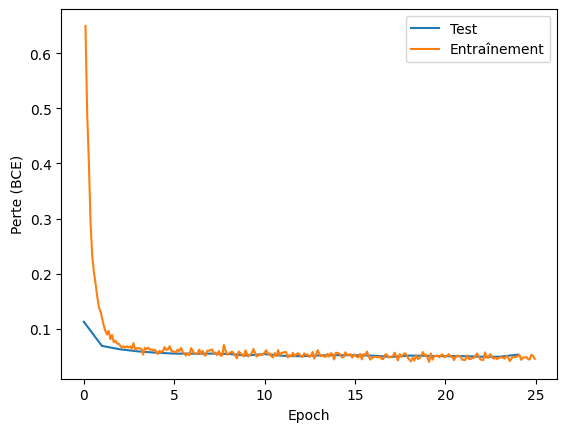

In [48]:
plt.plot(parsed_tensorboard["Loss/test"]["step"], parsed_tensorboard["Loss/test"]["value"], label="Test")
plt.plot(parsed_tensorboard["Loss/train"]["step"] / 534, parsed_tensorboard["Loss/train"]["value"], label="Entraînement")
plt.ylabel("Perte (BCE)")
plt.xlabel("Epoch")
plt.legend()
plt.show()

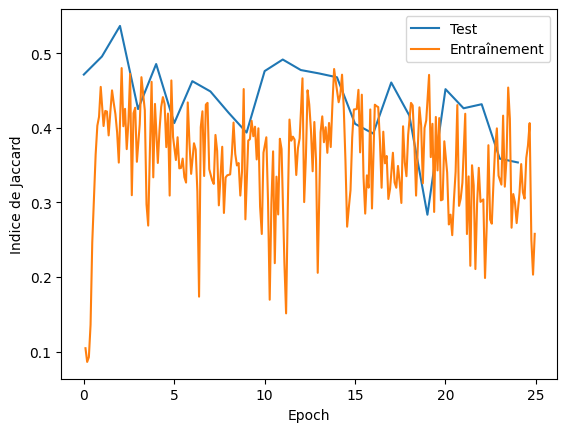

In [45]:
plt.plot(parsed_tensorboard["Jaccard/test"]["step"], parsed_tensorboard["Jaccard/test"]["value"], label="Test")
plt.plot(parsed_tensorboard["Jaccard/train"]["step"] / 534, parsed_tensorboard["Jaccard/train"]["value"], label="Entraînement")
plt.ylabel("Indice de Jaccard")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [8]:

torch.manual_seed(seed)

test_dataset = SolarPanelDataset(
        img_path, xlsx_path, "seg", "pan", False, p_test, seed
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
    persistent_workers=True,
)

In [15]:
torch.backends.cudnn.benchmark = True
model = torch.load("/home/onyxia/work/StatApp/data/WEIGHTS/model_bdappv_seg.pth", weights_only=False, map_location=device)
state_dict = torch.load(seg_weights_path, weights_only=True)
remove_prefix = '_orig_mod.'
state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = torch.compile(model).to(device)
model.eval()


OptimizedModule(
  (_orig_mod): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 